In [1]:
from tqdm.notebook import tqdm
import xml.etree.ElementTree as et
import csv

import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns

from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from ndspflow.workflows import WorkFlow

from timescales.fit import PSD
from timescales.autoreg import compute_ar_spectrum
from timescales.utils import create_windows

## Minimal Preprocessing Functions

These functions are used to read signals for LFP and spiking data into memory. They are also used to read metadata, channel information, and behavioral annotations. Once this is complete, we pass the np.arrays over to ndspflow's workflow manager to compute and fit power spectral density (PSD).

In [2]:
# Root directory to crncs:fcx-1 data
dirpath = '/Users/ryanhammonds/Desktop/fcx-1'

def read_xml(file):
    """Extracts metadata from .xml files."""
    
    tree = et.parse(file)
    root = tree.getroot()
    
    meta = _read_xml(root)
    
    return meta
    
    
def _read_xml(root, info={}):

    for child in root:
        
        # Recurse
        parents = ['acquisitionSystem', 'fieldPotentials']
        if child.tag in parents:
            _read_xml(child, info)
            
        # Extract
        if child.tag == 'nBits':
            info['n_bits'] = int(child.text)
        elif child.tag == 'nChannels':
            info['n_channels'] = int(child.text)
        elif child.tag == 'lfpSamplingRate':
            info['fs_lfp'] = float(child.text)
            
    return info


def read_channels(f):
    """Read channel labels from csv."""
    
    with open(f) as csvfile:

        reader = csv.reader(csvfile, delimiter=' ', quotechar='|')

        channel_map = {}

        for row in reader:

            ch, loc = row[0].split(',')
            ch = int(ch)
            loc = None if loc == '' else loc
            channel_map[ch] = loc
    
    return channel_map


def read_spikes(base, fs, dirpath=dirpath):
    """Read spikes as sum spikes across E/I sub-units"""
    
    subtype_dict = loadmat(f'{dirpath}/{base}/{base}_SSubtypes.mat')
    subtype_e = subtype_dict['Se_CellFormat'][0]
    subtype_i = subtype_dict['Si_CellFormat'][0]

    n_seconds = np.ceil(max([*[np.max(i) for i in subtype_i], 
                             *[np.max(i) for i in subtype_e]]))

    spikes = np.zeros((2, int(n_seconds * fs)))

    for sind, subtype in enumerate([subtype_e, subtype_i]):
        for s in subtype:
            spikes[sind, (s[:, 0] * fs).astype(int)] = 1
            
    spikes_e = spikes[0]
    spikes_i = spikes[1]
    
    return spikes_e, spikes_i


def read_lfp(base, dirpath=dirpath):
    """Read LFP for mPFC electrodes."""
    
    # Metadata / recording parameters
    f = f'{dirpath}/{base}/{base}.xml'
    meta = read_xml(f)
    fs = meta['fs_lfp']
    n_channels = meta['n_channels']

    # Channel map
    f = f'{dirpath}/{base}/{base}_ChannelAnatomy.csv'
    cm = read_channels(f)

    # Signal indices for mPFC
    inds = [k for k, v in cm.items() if v == 'mPFC']

    # Read LFP
    f = f'{dirpath}/{base}/{base}.eeg'

    with open(f, mode='rb') as file:
        content = file.read()

    sigs = np.frombuffer(content, dtype=np.int16)
    sigs = sigs[:int((len(sigs) // n_channels)*n_channels)]
    sigs = sigs.reshape(-1, n_channels).T

    # Limit to mPFC
    sigs = sigs[inds]
    
    return sigs, fs


def read_annotations(base, fs, win_len, win_spacing, dirpath=dirpath):
    """Read sample indices corresponding to wake and nrem."""
    
    # Windows
    win_len = int(win_len*fs)
    win_spacing = int(win_spacing*fs)
    
    # Extract behavioral data
    beh_file = f'{dirpath}/{base}/{base}_WSRestrictedIntervals.mat'
    beh = loadmat(beh_file)

    nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
    wake = beh['WakeTimePairFormat'].astype(int) *  fs

    # Window by trial type
    wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
    nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

    start_end_wake = np.vstack((wake_starts, wake_ends)).T.astype(int)
    start_end_nrem = np.vstack((nrem_starts, nrem_ends)).T.astype(int)
    
    return start_end_wake, start_end_nrem

In [10]:
# Settings
ar_order = 10
f_range_lfp = (.01, 20)
f_range_spikes = (.01, 20)

# Window length/spacing, in seconds
win_len = 5
win_spacing = 5

# Spikes
fs_spikes = 20000
bin_size = 100

# Specparam
fooof_init = {
    'aperiodic_mode': 'knee_constant',
    'max_n_peaks': 4,
    'peak_threshold': 2.5
}

# Function for binnning spikes
def bin_spikes(spikes, bin_size):
    
    from neurodsp.utils.norm import normalize_sig

    spikes_bin = normalize_sig(
        spikes.reshape(-1, bin_size).sum(axis=1), 0, 1)
    
    return spikes_bin

## Raw Data $\rightarrow$ Model Fits

Below, annotations for wake and non-REM are used to split the signal (both LFP and spikes) into 5 second windows. The workflows are defined for:

1. LFP : Wake
2. LFP : Non-REM
3. Spikes : Excitatory : Wake
4. Spikes : Inhibitory : Wake
5. Spikes : Excitatory : Non-REM
6. Spikes : Excitatory : Wake

Each workflow involves computing and fitting an autoregressive PSD. The workflow for spikes additionally includes binning spikes.

In [11]:
# Files for 4 rats that have the same:
#   1. Electrode Location (mPFC)
#   2. Wake activity (homecage)
bases = [
    '20140526_277um',
    '20140527_421um',
    '20140528_565um',
    #'Dino_061814_mPFC',
    #  -> excessive number of failed fits
    #'Dino_061914_mPFC'
    #  -> rat had a shape mismatch
    #     (n_channels not divisible into data length)
]

# Track results
results_lfp_wake = []
results_lfp_nrem = []

results_spikes_e_wake = []
results_spikes_e_nrem = []

results_spikes_i_wake = []
results_spikes_i_nrem = []

# Iterate over each animal
for base in bases:
    
    print(f'Running: {base}')
    
    # LFP: read
    lfp, fs_lfp = read_lfp(base)
    
    # LFP: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_lfp, win_len, win_spacing)

    # LFP: split into wake and nrem, shaped as: (n_channels, n_epochs, n_samples)
    lfp_wake = np.array([lfp[:, s:e] for s, e in start_end_wake])
    lfp_wake = np.swapaxes(lfp_wake, 0, 1)

    lfp_nrem = np.array([lfp[:, s:e] for s, e in start_end_nrem])
    lfp_nrem = np.swapaxes(lfp_nrem, 0, 1)

    # Spikes: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_spikes, win_len, win_spacing)

    # Spikes: read
    spikes_e, spikes_i = read_spikes(base, fs_spikes)
    
    # Spikes: annotations
    #   Need to recompute annotations due to differences
    #   in lfp and spike sampling rate.
    spikes_i_wake = np.array([spikes_i[s:e] for s, e in start_end_wake])
    spikes_e_wake = np.array([spikes_e[s:e] for s, e in start_end_wake])

    spikes_i_nrem = np.array([spikes_i[s:e] for s, e in start_end_nrem])
    spikes_e_nrem = np.array([spikes_e[s:e] for s, e in start_end_nrem])

    # Prevent OOM
    del lfp, spikes_e, spikes_i
    
    # Define and run workflows
    # LFP: Wake
    wf_lfp_wake = WorkFlow(y_array=lfp_wake)
    wf_lfp_wake.transform(compute_ar_spectrum, fs_lfp, ar_order, f_range=f_range_lfp)
    # wf_lfp_wake.fit(PSD(), method='fooof', fooof_init=fooof_init, n_jobs=1)
    wf_lfp_wake.fit(PSD(), method='huber')
    wf_lfp_wake.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # LFP: NREM
    wf_lfp_nrem = WorkFlow(y_array=lfp_nrem)
    wf_lfp_nrem.transform(compute_ar_spectrum, fs_lfp, ar_order, f_range=f_range_lfp)
    # wf_lfp_nrem.fit(PSD(), method='fooof', fooof_init=fooof_init, n_jobs=1)
    wf_lfp_nrem.fit(PSD(), method='huber')
    wf_lfp_nrem.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Inhibitory : Wake
    wf_spikes_i_wake = WorkFlow(y_array=spikes_i_wake)

    wf_spikes_i_wake.transform(bin_spikes, bin_size, mode='notebook')
    wf_spikes_i_wake.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)

    # wf_spikes_i_wake.fit(PSD(), method='fooof', fooof_init=fooof_init)
    wf_spikes_i_wake.fit(PSD(), method='huber')
    wf_spikes_i_wake.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Excitatory : Wake
    wf_spikes_e_wake = WorkFlow(y_array=spikes_e_wake)

    wf_spikes_e_wake.transform(bin_spikes, bin_size, mode='notebook')
    wf_spikes_e_wake.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)

    # wf_spikes_e_wake.fit(PSD(), method='fooof', fooof_init=fooof_init)
    wf_spikes_e_wake.fit(PSD(), method='huber')
    wf_spikes_e_wake.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Inhibitory : NREM
    wf_spikes_i_nrem = WorkFlow(y_array=spikes_i_nrem)

    wf_spikes_i_nrem.transform(bin_spikes, bin_size, mode='notebook')
    wf_spikes_i_nrem.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)

    # wf_spikes_i_nrem.fit(PSD(), method='fooof', fooof_init=fooof_init)
    wf_spikes_i_nrem.fit(PSD(), method='huber')
    wf_spikes_i_nrem.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Excitatory : NREM
    wf_spikes_e_nrem = WorkFlow(y_array=spikes_e_nrem)

    wf_spikes_e_nrem.transform(bin_spikes, bin_size, mode='notebook')
    wf_spikes_e_nrem.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)

    # wf_spikes_e_nrem.fit(PSD(), method='fooof', fooof_init=fooof_init)
    wf_spikes_e_nrem.fit(PSD(), method='huber')
    wf_spikes_e_nrem.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)
    
    # Store results
    results_lfp_wake.append(wf_lfp_wake.results)
    results_lfp_nrem.append(wf_lfp_nrem.results)
    
    results_spikes_e_wake.append(wf_spikes_e_wake.results)
    results_spikes_e_nrem.append(wf_spikes_e_nrem.results)

    results_spikes_i_wake.append(wf_spikes_i_wake.results)
    results_spikes_i_nrem.append(wf_spikes_i_nrem.results)
    
    del lfp_wake, lfp_nrem, spikes_e_nrem, spikes_i_nrem, spikes_e_wake, spikes_i_wake

Running: 20140526_277um


Running Workflow:   0%|          | 0/13664 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/17152 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/427 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/427 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/536 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/536 [00:00<?, ?it/s]

Running: 20140527_421um


Running Workflow:   0%|          | 0/10720 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/12096 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/335 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/335 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/378 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/378 [00:00<?, ?it/s]

Running: 20140528_565um


Running Workflow:   0%|          | 0/5024 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/17280 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/157 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/157 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/540 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/540 [00:00<?, ?it/s]

In [26]:
def flatten_results(results, std=2., units='ms'):
    
    taus = []
    for res in results:
    
        inds = np.where(
            (res <= (res.mean() + (std * res.std()))) &
            (res >= (res.mean() - (std * res.std())))
        )[0]
        
        print(f"total:{len(res)}, kept:{len(inds)}")
        
        res = res[inds].flatten()
        
        if units == 'ms':
            res *= 1000
            
        taus.append(res)
        
    return taus

In [27]:
taus_lfp_wake = [i[:, :, 0].flatten().astype(float) for i in results_lfp_wake]
taus_lfp_nrem = [i[:, :, 0].flatten().astype(float) for i in results_lfp_nrem]

taus_e_wake = [i[:, 0] for i in results_spikes_e_wake]
taus_i_wake = [i[:, 0] for i in results_spikes_i_wake]

taus_e_nrem = [i[:, 0] for i in results_spikes_e_nrem]
taus_i_nrem = [i[:, 0] for i in results_spikes_i_nrem]

# Remove outliers
std=2

taus_lfp_wake = flatten_results(taus_lfp_wake, std)
taus_lfp_nrem = flatten_results(taus_lfp_nrem, std)

taus_e_wake = flatten_results(taus_e_wake, std)
taus_e_nrem = flatten_results(taus_e_nrem, std)

taus_i_wake = flatten_results(taus_i_wake, std)
taus_i_nrem = flatten_results(taus_i_nrem, std)

total:13664, kept:13180
total:10720, kept:10469
total:5024, kept:4780
total:17152, kept:16575
total:12096, kept:11785
total:17280, kept:16647
total:427, kept:423
total:335, kept:332
total:157, kept:150
total:536, kept:503
total:378, kept:365
total:540, kept:524
total:427, kept:394
total:335, kept:316
total:157, kept:149
total:536, kept:502
total:378, kept:358
total:540, kept:532


In [58]:
13664 + 10720 + 5024 + 17152+12096+17280+427+335+157+536+378+540+427+335+157+536+378+540

80682

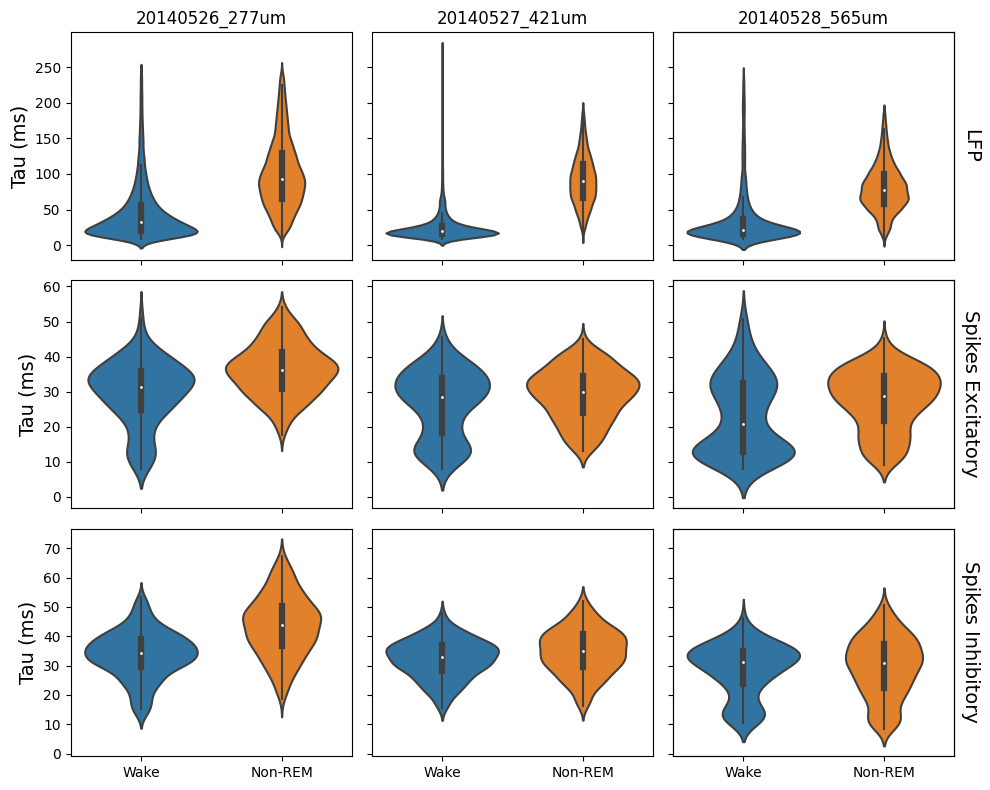

In [56]:
import seaborn as sns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8), sharey='row', sharex=True)

for i in range(3):
    sns.violinplot([taus_lfp_wake[i], taus_lfp_nrem[i]], showfliers=False, ax=axes[0][i])
    sns.violinplot([taus_e_wake[i], taus_e_nrem[i]], showfliers=False, ax=axes[1][i])
    sns.violinplot([taus_i_wake[i], taus_i_nrem[i]], showfliers=False, ax=axes[2][i])
    
    
for i, base in enumerate(bases):
    axes[0][i].set_title(base)
    
axes[2, 0].set_xticklabels(['Wake', 'Non-REM'])

for ax in axes:
    ax[0].set_ylabel('Tau (ms)', size=14)
    
labels = ['LFP', 'Spikes Excitatory', 'Spikes Inhibitory']

for i in range(3):
    ax = axes[i][2].twinx()
    ax.set_yticks([])
    ax.set_ylabel(labels[i], rotation=-90, size=14,labelpad=15)
    
plt.tight_layout()